In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from fastai import *
from fastai.vision import *

In [4]:
from pathlib import Path

In [5]:
path = Path('data/sanfrancisco/')
path.ls()

[PosixPath('data/sanfrancisco/road'),
 PosixPath('data/sanfrancisco/sat'),
 PosixPath('data/sanfrancisco/ter')]

In [6]:
path_lbl = path/'road'
path_img = path/'sat'

## Data

In [7]:
fnames = get_image_files(path_img)
fnames[:3]

[PosixPath('data/sanfrancisco/sat/35.png'),
 PosixPath('data/sanfrancisco/sat/51.png'),
 PosixPath('data/sanfrancisco/sat/20.png')]

In [8]:
lbl_names = get_image_files(path_lbl)
lbl_names[:3]

[PosixPath('data/sanfrancisco/road/35.png'),
 PosixPath('data/sanfrancisco/road/51.png'),
 PosixPath('data/sanfrancisco/road/20.png')]

In [9]:
len(lbl_names)

146

torch.Size([3, 490, 490])


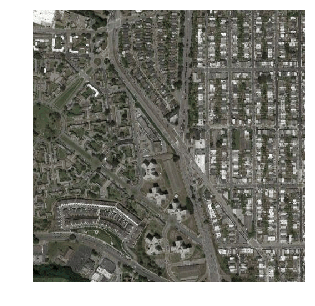

In [10]:
img_f = fnames[0]
img = open_image(img_f)
print(img.shape)
img.show(figsize=(5,5))

In [11]:
get_y_fn = lambda x: path_lbl/f'{x.stem}{x.suffix}'

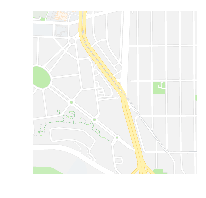

In [14]:
im_l = open_image(get_y_fn(img_f))
im_l.show()

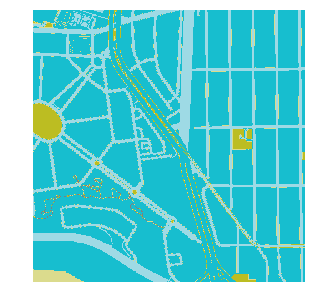

In [13]:
mask = open_mask(get_y_fn(img_f))
mask.show(figsize=(5,5), alpha=1)

In [16]:
src_size = np.array(mask.shape[1:])
src_size, mask.data

(array([490, 490]), tensor([[[234, 234, 234,  ..., 242, 242, 242],
          [234, 234, 234,  ..., 242, 242, 242],
          [234, 234, 234,  ..., 242, 242, 242],
          ...,
          [220, 220, 220,  ..., 238, 242, 242],
          [220, 220, 220,  ..., 238, 242, 242],
          [220, 220, 220,  ..., 238, 242, 242]]]))

Need to find out all the codes present

In [ ]:
from collections import Counter

In [ ]:
total_counter = Counter([])

for fnames in path_lbl.iterdir():
    mask = open_mask(str(fnames))
    total_counter += Counter(mask.data.numpy().reshape(-1))

In [ ]:
total_counter.most_common(30)

In [ ]:
import time

In [ ]:
for fnames in path_lbl.iterdir():
    mask = open_mask(str(fnames))
    mask.show()
    time.sleep(1)

## Datasets

In [17]:
size = src_size//2
bs = 8

In [18]:
src = (SegmentationItemList.from_folder(path_img)
       .split_by_fname_file('../valid.txt')
       .label_from_func(get_y_fn, classes=codes))

FileNotFoundError: [Errno 2] No such file or directory: 'data/sanfrancisco/sat/../valid.txt'

In [ ]:
data = (src.transform(get_transforms(), size=size, tfm_y=True)
        .databunch(bs=bs)
        .normalize(imagenet_stats))

In [ ]:
data.show_batch(2, figsize=(10,7))

In [ ]:
data.show_batch(2, figsize=(10,7), ds_type=DatasetType.Valid)

## Model

In [ ]:
name2id = {v:k for k,v in enumerate(codes)}
void_code = name2id['Void']

def acc_camvid(input, target):
    target = target.squeeze(1)
    mask = target != void_code
    return (input.argmax(dim=1)[mask]==target[mask]).float().mean()

In [ ]:
metrics=acc_camvid
# metrics=accuracy

In [ ]:
learn = Learner.create_unet(data, models.resnet34, metrics=metrics)

In [ ]:
lr_find(learn)
learn.recorder.plot()

In [ ]:
lr=1e-2

In [ ]:
learn.fit_one_cycle(10, slice(lr))

In [ ]:
learn.save('stage-1')

In [ ]:
learn.load('stage-1');

In [ ]:
learn.show_results()

In [ ]:
learn.unfreeze()

In [ ]:
lr_find(learn)
learn.recorder.plot()

In [ ]:
lrs = slice(1e-5,lr/5)

In [ ]:
learn.fit_one_cycle(12, lrs)

In [ ]:
learn.recorder.plot_losses()

In [ ]:
learn.recorder.plot_lr()

In [ ]:
learn.save('stage-2');

## Go big

You may have to restart your kernel and come back to this stage if you run out of memory, and may also need to decrease `bs`.

In [ ]:
size = src_size
bs=4

In [ ]:
data = (src.transform(get_transforms(), size=size, tfm_y=True)
        .databunch(bs=bs)
        .normalize(imagenet_stats))

In [ ]:
learn = Learner.create_unet(data, models.resnet34, metrics=metrics)

In [ ]:
learn.load('stage-2');

In [ ]:
lr_find(learn)
learn.recorder.plot()

In [ ]:
lr=1e-3

In [ ]:
learn.fit_one_cycle(10, slice(lr))

In [ ]:
learn.save('stage-1-big')

In [ ]:
learn.load('stage-1-big');

In [ ]:
learn.unfreeze()

In [ ]:
lrs = slice(1e-6,lr)

In [ ]:
learn.fit_one_cycle(10, lrs, wd=1e-3)

In [ ]:
learn.save('stage-2-big')

In [ ]:
learn.load('stage-2-big')

In [ ]:
learn.show_results()